In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/RT Project/'
import pandas as pd
data1 = pd.read_csv('data/Phones_accelerometer.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/RT Project


In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from models import FullyConnectedNetwork,RecursiveNeuralNetwork

# Preprocess Data

In [ ]:
def downSampleData(dataset, downsamplesize=100000):
  dataset = np.asarray(dataset)
  downSizeFeatureDatas = []
  yValue = ['bike','sit','stairsdown','stairsup','stand','walk']
  for output in yValue:
    typeIndex = np.where(dataset[:,4]==output)[0]
    downSizeFeatureIndex = np.random.choice(typeIndex, size=downsamplesize, replace=False)
    downSizeFeatureData = dataset[downSizeFeatureIndex]
    downSizeFeatureDatas.append(downSizeFeatureData)
  dataDown = np.concatenate((downSizeFeatureDatas[0],downSizeFeatureDatas[1],downSizeFeatureDatas[2],downSizeFeatureDatas[3],downSizeFeatureDatas[4],downSizeFeatureDatas[5]),axis=0)
  target = dataDown[:,4]
  feature = dataDown[:,0:3]

  for i in range(len(target)):
    target[i] = str(target[i])
  enc = LabelEncoder().fit(target)
  target = enc.transform(target)

  #to add userdetails to dataset
  userDetails = dataDown[:,3]
  for i in range(len(userDetails)):
    userDetails[i] = str(userDetails[i])
  userEnc = LabelEncoder().fit(userDetails)
  userDetails = userEnc.transform(userDetails)

  dataDown = np.concatenate((feature,userDetails[:,None]),axis=1)
  dataDown = np.concatenate((dataDown,target[:,None]),axis=1)
  return dataDown,target,enc.classes_


In [ ]:
def preProcessData(processData,down_size):
  processData = processData.drop(labels = ['Arrival_Time','Creation_Time','Index', 'Model', 'Device'], axis=1)
  to_drop = ['null']	#To drop the null values from both data1 and data2
  processData = processData[~processData['gt'].isin(to_drop)]
  processData = processData.dropna()
  processData = processData.reset_index(drop=True)
  yData = processData['gt']
  dataDown = downSampleData(processData,100000)
  return dataDown


# Down Sample Data

In [ ]:
downSampledData,yData,yDataLabels = preProcessData(data1,100000)

# Train and Test Split

In [ ]:
batch_size = 100
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(downSampledData)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(test_indices)

downSampledData=downSampledData.astype(float)
downSampledData = torch.from_numpy(downSampledData).float()


train_loader = torch.utils.data.DataLoader(downSampledData,batch_size=batch_size,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(downSampledData, batch_size=batch_size,sampler=valid_sampler)

# Fully Connected Network

In [ ]:
noEpoch = 50
noInput = downSampledData.shape[1]-1
fnn = FullyConnectedNetwork(noEpoch,noInput)

## Train and Test Neural Network for different values of epoch

**Hyper Parameters**

1.   No of layers = 6
2.   BatchSize = 100
3.   Epoch = 0 to 50
4.   Learning Rate = 0.001

In [ ]:
trainAccuracy,testAccuracy = fnn.train(train_loader,test_loader)

Train Epoch: 0 [0/600000 (0%)]	Loss: 1.805050
Train Epoch: 0 [100000/600000 (21%)]	Loss: 1.512992
Train Epoch: 0 [200000/600000 (42%)]	Loss: 1.466309
Train Epoch: 0 [300000/600000 (62%)]	Loss: 1.345182
Train Epoch: 0 [400000/600000 (83%)]	Loss: 1.291305
Test Accuracy: 0.40970416666666665

Test set: Average loss: 0.0000,  Accuracy: 53826/120000 (45%)

Train Epoch: 1 [0/600000 (0%)]	Loss: 1.305027
Train Epoch: 1 [100000/600000 (21%)]	Loss: 1.228406
Train Epoch: 1 [200000/600000 (42%)]	Loss: 1.207340
Train Epoch: 1 [300000/600000 (62%)]	Loss: 1.093790
Train Epoch: 1 [400000/600000 (83%)]	Loss: 1.049381
Test Accuracy: 0.5162395833333333

Test set: Average loss: 0.0000,  Accuracy: 64465/120000 (54%)

Train Epoch: 2 [0/600000 (0%)]	Loss: 0.989057
Train Epoch: 2 [100000/600000 (21%)]	Loss: 1.005652
Train Epoch: 2 [200000/600000 (42%)]	Loss: 0.980941
Train Epoch: 2 [300000/600000 (62%)]	Loss: 1.023527
Train Epoch: 2 [400000/600000 (83%)]	Loss: 0.989837
Test Accuracy: 0.5670708333333333

Test s

## Model Accuracy Plot

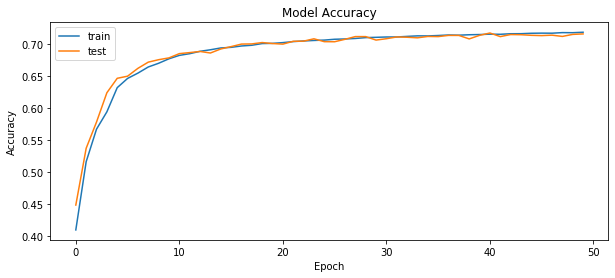

In [ ]:
rcParams['figure.figsize'] = 10, 4
import matplotlib.pyplot as plt
plt.plot(trainAccuracy)
plt.plot(testAccuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Loss Plot

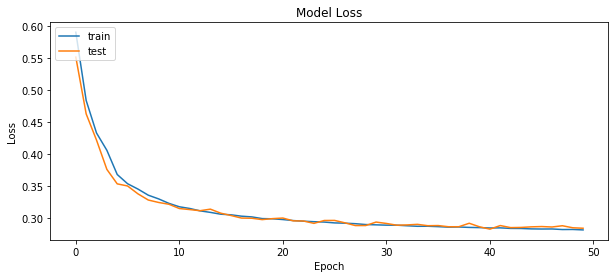

In [ ]:
rcParams['figure.figsize'] = 10, 4
import matplotlib.pyplot as plt
trainLoss = np.asarray(trainAccuracy)
trainLoss = 1-trainLoss
testLoss = np.asarray(testAccuracy)
testLoss = 1-testLoss
plt.plot(trainLoss)
plt.plot(testLoss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test Net

In [ ]:
yTrue,yPred,pred_fnn = fnn.predict(test_loader)


Test set: Average loss: 0.0000,  Accuracy: 85900/120000 (72%)



## Confusion Matrix

['bike' 'sit' 'stairsdown' 'stairsup' 'stand' 'walk']


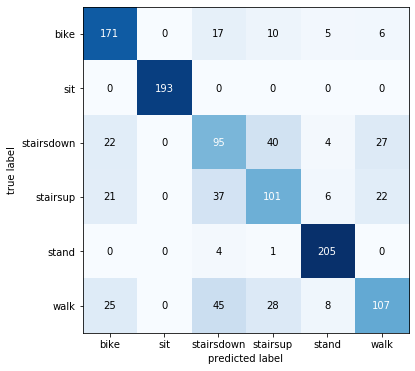

yDataLabels  ['bike' 'sit' 'stairsdown' 'stairsup' 'stand' 'walk']


In [ ]:
CM = confusion_matrix(yTrue, yPred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(10, 6))
print(yDataLabels)
x=plt.xticks((0,1,2,3,4,5)  ,yDataLabels)
y=plt.yticks((0,1,2,3,4,5),yDataLabels)
plt.show()
print('yDataLabels ', yDataLabels)

# Recurrent Neural Network

### RNN Net

In [ ]:
downSampledData,yData,yDataLabels = preProcessData(data1,100000)
batch_size = 1000
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(downSampledData)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(test_indices)

downSampledData=downSampledData.astype(float)
downSampledData = torch.from_numpy(downSampledData).float()


train_loader = torch.utils.data.DataLoader(downSampledData,batch_size=batch_size,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(downSampledData, batch_size=batch_size,sampler=valid_sampler)

## Train and Test Neural Network for different values of epoch

**Hyper Parameters**

1.   No of Neurons = 10
2.   BatchSize = 1000
3.   Epoch = 50
4.   Learning Rate = 0.01

In [ ]:
noOfNeurons = 10
epochs = 50
noOfInputs = 4

In [ ]:
rnn = RecursiveNeuralNetwork(noOfInputs,noOfNeurons,epochs)
rtrain_acc,rtest_acc,rloss = rnn.train(train_loader,test_loader)
RNN_acc,RNN_targ,RNN_ypred = rnn.predict(test_loader)

Epoch Value:  0
Epoch:  0 | Loss: 1.3451 | Train Accuracy: 43.49
Epoch Value:  1
Epoch:  1 | Loss: 1.2330 | Train Accuracy: 47.19
Epoch Value:  2
Epoch:  2 | Loss: 1.2075 | Train Accuracy: 47.79
Epoch Value:  3
Epoch:  3 | Loss: 1.1601 | Train Accuracy: 49.66
Epoch Value:  4
Epoch:  4 | Loss: 1.1062 | Train Accuracy: 51.98
Epoch Value:  5
Epoch:  5 | Loss: 1.0920 | Train Accuracy: 53.08
Epoch Value:  6
Epoch:  6 | Loss: 1.0824 | Train Accuracy: 53.71
Epoch Value:  7
Epoch:  7 | Loss: 1.0632 | Train Accuracy: 54.67
Epoch Value:  8
Epoch:  8 | Loss: 1.0528 | Train Accuracy: 54.89
Epoch Value:  9
Epoch:  9 | Loss: 1.0475 | Train Accuracy: 55.09
Epoch Value:  10
Epoch:  10 | Loss: 1.0429 | Train Accuracy: 55.30
Epoch Value:  11
Epoch:  11 | Loss: 1.0379 | Train Accuracy: 55.47
Epoch Value:  12
Epoch:  12 | Loss: 1.0352 | Train Accuracy: 55.61
Epoch Value:  13
Epoch:  13 | Loss: 1.0325 | Train Accuracy: 55.73
Epoch Value:  14
Epoch:  14 | Loss: 1.0291 | Train Accuracy: 56.02
Epoch Value:  1

## Test Net

In [ ]:
RNN_acc,RNN_targ,RNN_ypred = rnn.predict(test_loader)

In [ ]:
print(RNN_acc)

56.22083333333333


## Confusion Matrix

['bike' 'sit' 'stairsdown' 'stairsup' 'stand' 'walk']


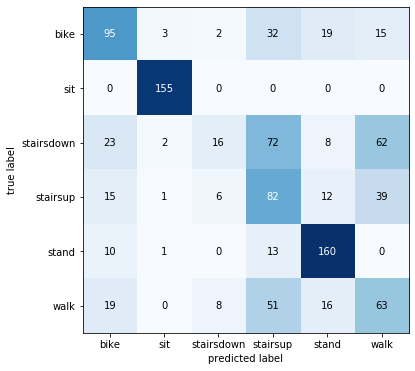

yDataLabels  ['bike' 'sit' 'stairsdown' 'stairsup' 'stand' 'walk']


In [ ]:
import matplotlib.pyplot as plt
CM = confusion_matrix(RNN_targ, RNN_ypred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(10, 6))
print(yDataLabels)
x=plt.xticks((0,1,2,3,4,5)  ,yDataLabels)
y=plt.yticks((0,1,2,3,4,5),yDataLabels)
plt.show()
print('yDataLabels ', yDataLabels)